In [1]:
import numpy as np
import scipy.stats

import emcee

import matplotlib.pyplot as plt

import matplotlib.style
matplotlib.style.use("bayesian_stats_course_tools.light")

import bayesian_stats_course_tools
bayesian_stats_course_tools.misc.display_markdown_and_setup_tex("")

<!-- Define LaTeX macros -->
$\def\E{\operatorname{E}}$
$\def\Var{\operatorname{Var}}$
$\def\Cov{\operatorname{Cov}}$
$\def\dd{\mathrm{d}}$
$\def\ee{\mathrm{e}}$
$\def\Norm{\mathcal{N}}$
$\def\Uniform{\mathcal{U}}$

<!-- MathJax needs them to be defined again for the non-inline environment -->
$$\def\E{\operatorname{E}}$$
$$\def\Var{\operatorname{Var}}$$
$$\def\Cov{\operatorname{Cov}}$$
$$\def\dd{\mathrm{d}}$$
$$\def\ee{\mathrm{e}}$$
$$\def\Norm{\mathcal{N}}$$
$$\def\Uniform{\mathcal{U}}$$

## Why we usually cannot sample directly in high dimensions

If we know $p(\vec x)$, we usually cannot directly draw samples from it.
- inverse transform sampling: need to compute the CDF (integrals!) and invert
- Could split up domain into bins and get a sample proportionally to large the probability in these bins are. But due to curse of dimensionality, in high dimensions, the bins are unlikely to resolve the high-probability region of the distribution.

One exception is the multivariate Normal distribution:
- Let $L$ be the Cholesky decomposition of the covariance matrix $\Sigma$: $L L^T = \Sigma$.
- Sample $x_i$ iid from a standard normal: $x_i \sim \Norm(0, 1)$.

Then $L\vec x \sim \Norm(0, \Sigma)$.

Implement the Metropolis-Hastings sampling routine for $n$ dimensions.

In [2]:
def sample_metropolis_hastings(n, x0,
                               target_distr,
                               sample_transition, transition_prob):
    x0 = np.atleast_1d(x0)
    n_rejected = 0
    n_accepted = 0
    for i in range(n):
        # Sample proposal
        x1 = sample_transition(x0)
        # Compute probabilities of the old and proposed states
        p0 = target_distr.pdf(x0)
        p1 = target_distr.pdf(x1)

        # Compute the transition probabilities
        q01 = transition_prob(x0, x1)
        q10 = transition_prob(x1, x0)

        a = p1/p0 * q01/q10

        u = np.random.uniform(size=1)
        if a >= u:
            # accept, proposed state becomes new state
            n_accepted += 1
            x0 = x1
            yield x1
        else:
            # reject, stay with current state
            n_rejected += 1
            yield x0

    acceptance_rate = n_accepted/(n_accepted + n_rejected)
    print(f"Acceptance rate: {acceptance_rate}")


Set up our target distribution (a bivariate Gaussian).

In [3]:
# Define variances and correlation
sigma_x = 2
sigma_y = 1
rho = 0.7

# Define mean and covariance
mean = np.array([1, 0.5])
cov = np.array([[sigma_x**2, sigma_x*sigma_y*rho],
                [sigma_x*sigma_y*rho, sigma_y**2]])

# Create distribution object
target_distr = scipy.stats.multivariate_normal(mean=mean, cov=cov)

Set up the sampling by defining the proposal (transition) distribution.

In [4]:
proposal_scale = 1.0

def sample_transition(x0):
    # Use an isotropic Gaussian as proposal
    return np.random.normal(loc=x0, scale=proposal_scale)

def transition_prob(x, y):
    # Use an isotropic Gaussian as proposal
    proposal_distr = scipy.stats.multivariate_normal(
        mean=y, cov=proposal_scale*np.eye(y.shape[0])
    )
    return proposal_distr.pdf(x)


Now do the sampling.

In [5]:
x0 = np.array([-5, 7])

samples = [x0]
for x in sample_metropolis_hastings(
        n=2000, x0=x0, 
        target_distr=target_distr,
        sample_transition=sample_transition,
        transition_prob=transition_prob):
    samples.append(x)

samples = np.array(samples)

Acceptance rate: 0.5555


Plot the chain, together with the size of the proposal.

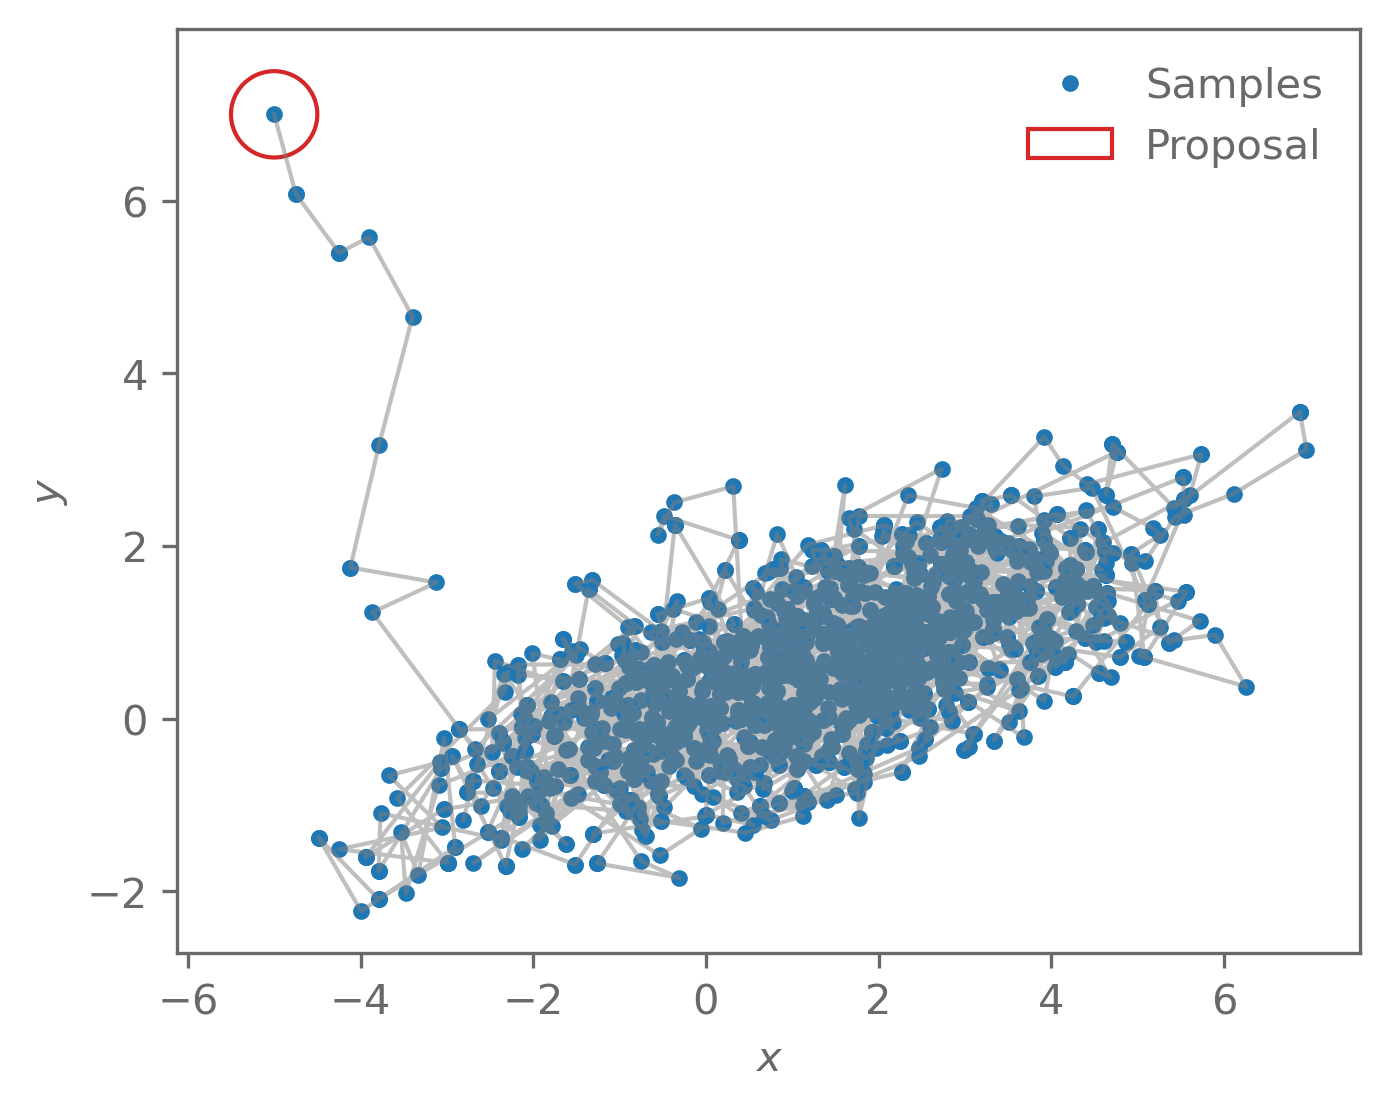

In [6]:
import matplotlib.patches

proposal_contour = matplotlib.patches.Ellipse(
    xy=x0, width=proposal_scale, height=proposal_scale,
    facecolor="none", edgecolor="C3", label="Proposal"
)

fig, ax = plt.subplots()

ax.plot(*samples.T, ".", label="Samples")
ax.plot(*samples.T, lw=1, alpha=0.5, color="grey")
ax.add_patch(proposal_contour)
ax.set_aspect("equal")
ax.legend(frameon=False)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$");

The chain needs some time to forget its starting position and start moving in the target distribution.

This start-up behaviour is called _burn-in_. Because samples from the chain during this burn-in period are not from the target distribution, we need to discard them.

This can also be seen when we plot the trace of the chain (a plot of sample vs time):


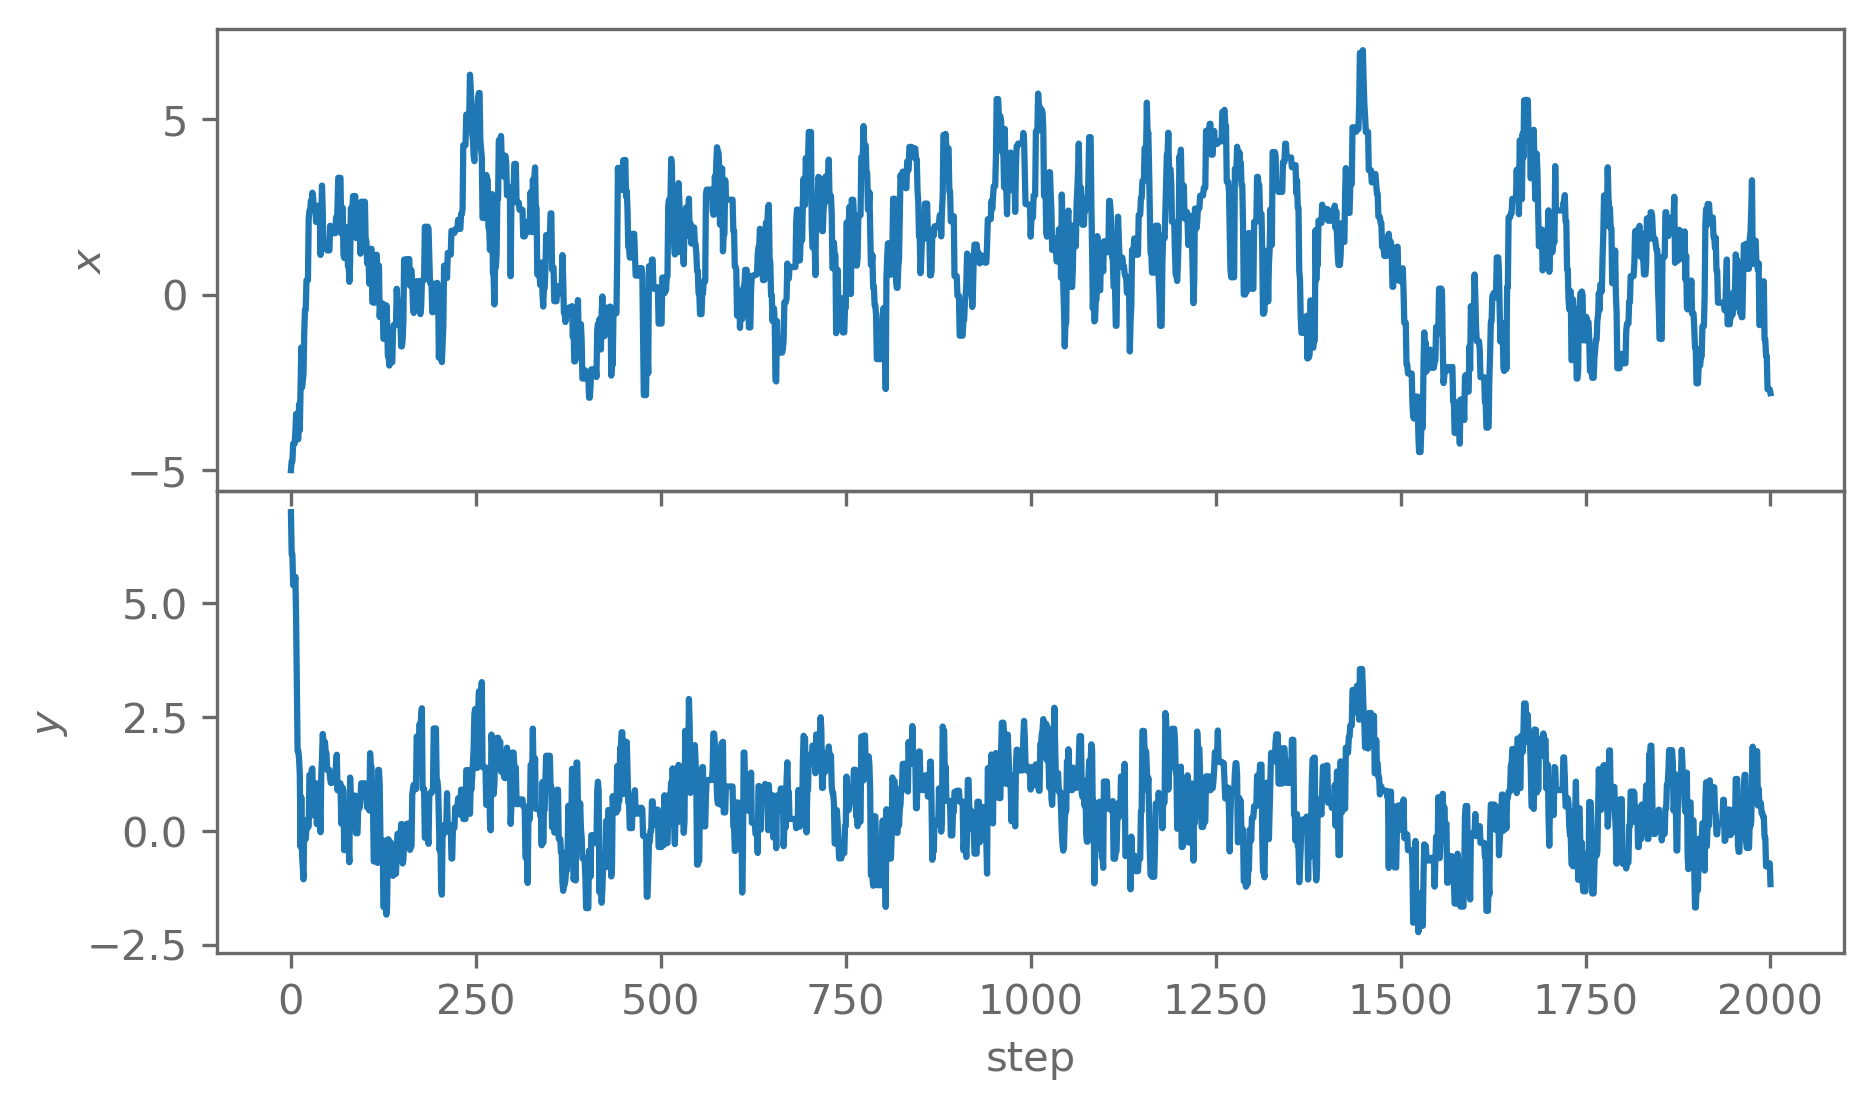

In [7]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=0)

ax[0].plot(samples[:,0])
ax[1].plot(samples[:,1])

ax[0].set_ylabel("$x$")
ax[1].set_ylabel("$y$")
ax[1].set_xlabel("step");

Beside visual inspection of the chain we cal also get a more quantitative estimate on how long the chain took to reach equilibrium.

This is done with the integrated autocorrelation time. The integrated autocorrelation time tells us how many steps need to be taken until the samples are approximately independent.

In practice, removing a couple of autocorrelation times takes care of the burn-in period. 

Because the samples are correlated within the autocorrelation time, we can thin out the chain by this amount to get approximately independent samples.

In [9]:
# The emcee.autocorr.integrated_time expect the samples to be in 
# shape of (n_samples, n_walker, n_dim). Since we have only one walker here, 
# we need insert an extra dimension

emcee.autocorr.integrated_time(samples[:, None, :])

array([30.69375999, 17.69747865])

In [10]:
# To get rid of the burn-in period, discard the first few autocorrelation times
processed_samples = samples[150:]

# We can also thin out the chain, since only ever 20th or sample is independent
processed_samples = processed_samples[::10]

# This leaves a lot fewer but well-behaved samples
processed_samples.shape

(186, 2)

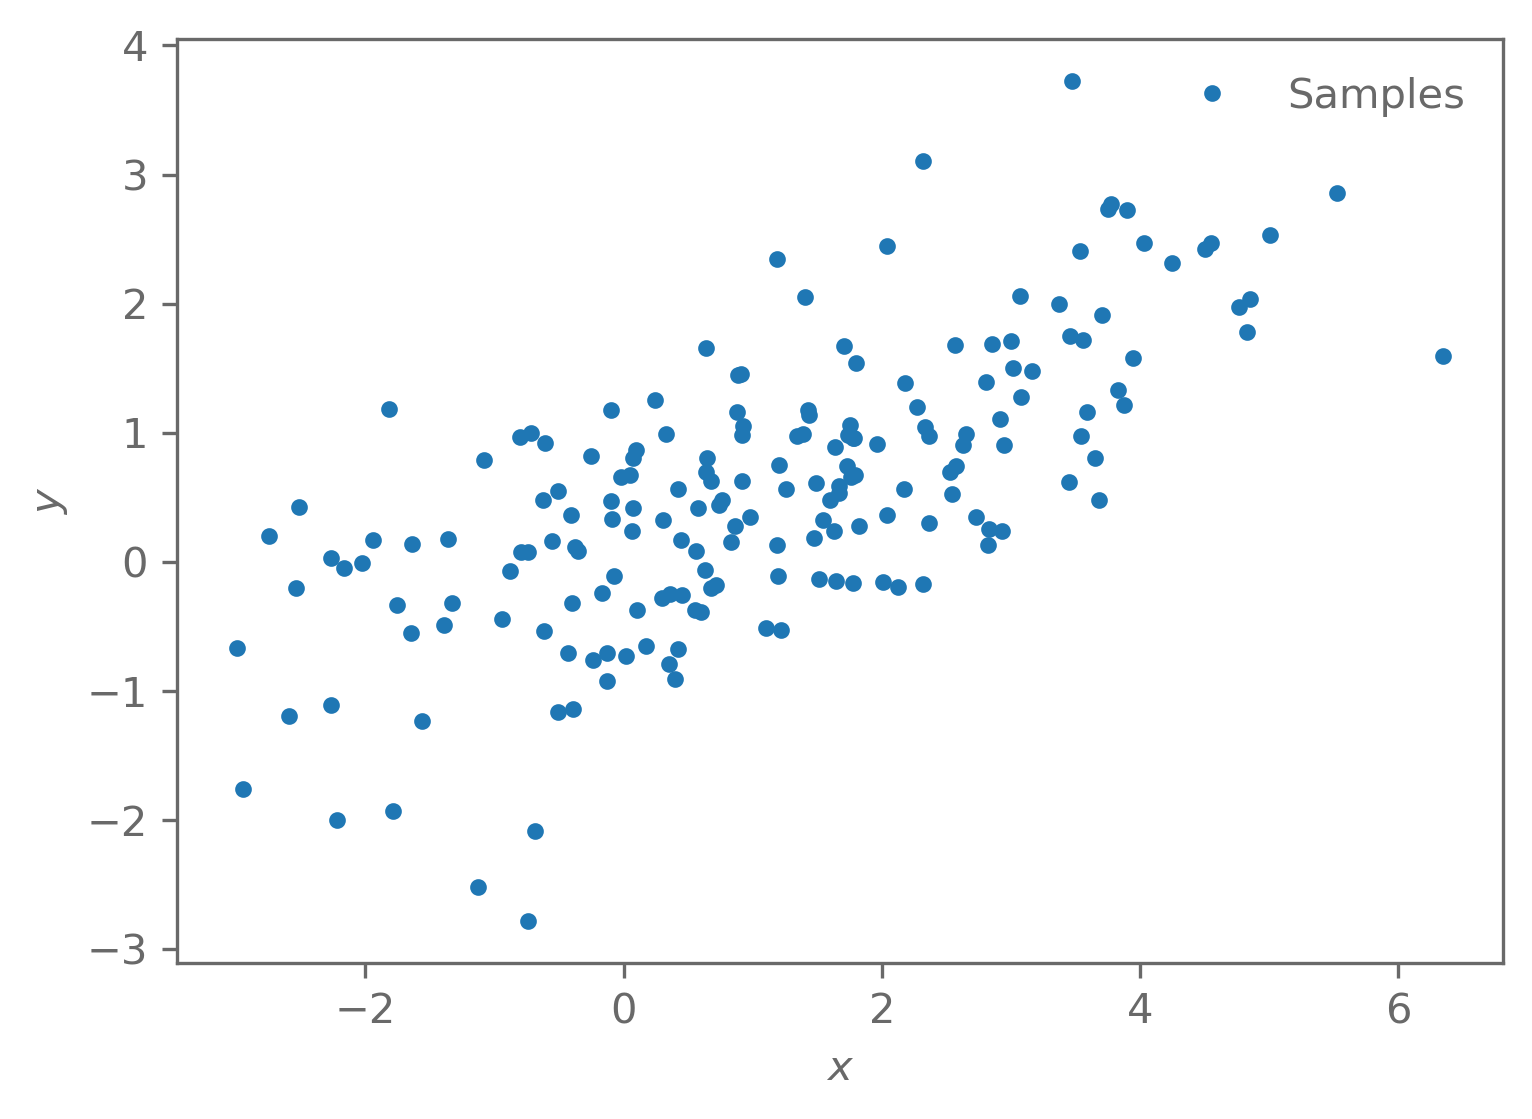

In [81]:
fig, ax = plt.subplots()

ax.plot(*processed_samples.T, ".", label="Samples")
ax.set_aspect("equal")
ax.legend(frameon=False)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$");

Now do the same thing with emcee (https://emcee.readthedocs.io), an affine invariant Markov chain Monte Carlo (MCMC) ensemble sampler.

Paper: https://arxiv.org/abs/1202.3665

In [68]:
# We need to define some extra information for emcee to run
n_param = 2      # Number of parameters that are being sampled
n_walker = 8     # Number of walkers that explore the distribution in parallel
n_step = 2000    # Number of steps to take

# Set up the start point. It needs to have shape (n_walker, n_param)
# We use a big scatter here for illustrative purposes. In a real analysis
# you usually want the walkers to start in a small ball around the peak
# of the distribution
theta_init = np.random.normal(scale=8, size=(n_walker, n_param))

# Set up the sampler
sampler = emcee.EnsembleSampler(
    nwalkers=n_walker,
    ndim=n_param,
    log_prob_fn=target_distr.logpdf    # The log probability of  the target distribution
)
# Run the sampler for n_step steps
state = sampler.run_mcmc(
    initial_state=theta_init,
    nsteps=n_step,
    progress=True
)

100%|██████████| 2000/2000 [00:00<00:00, 3100.22it/s]


Text(0, 0.5, '$y$')

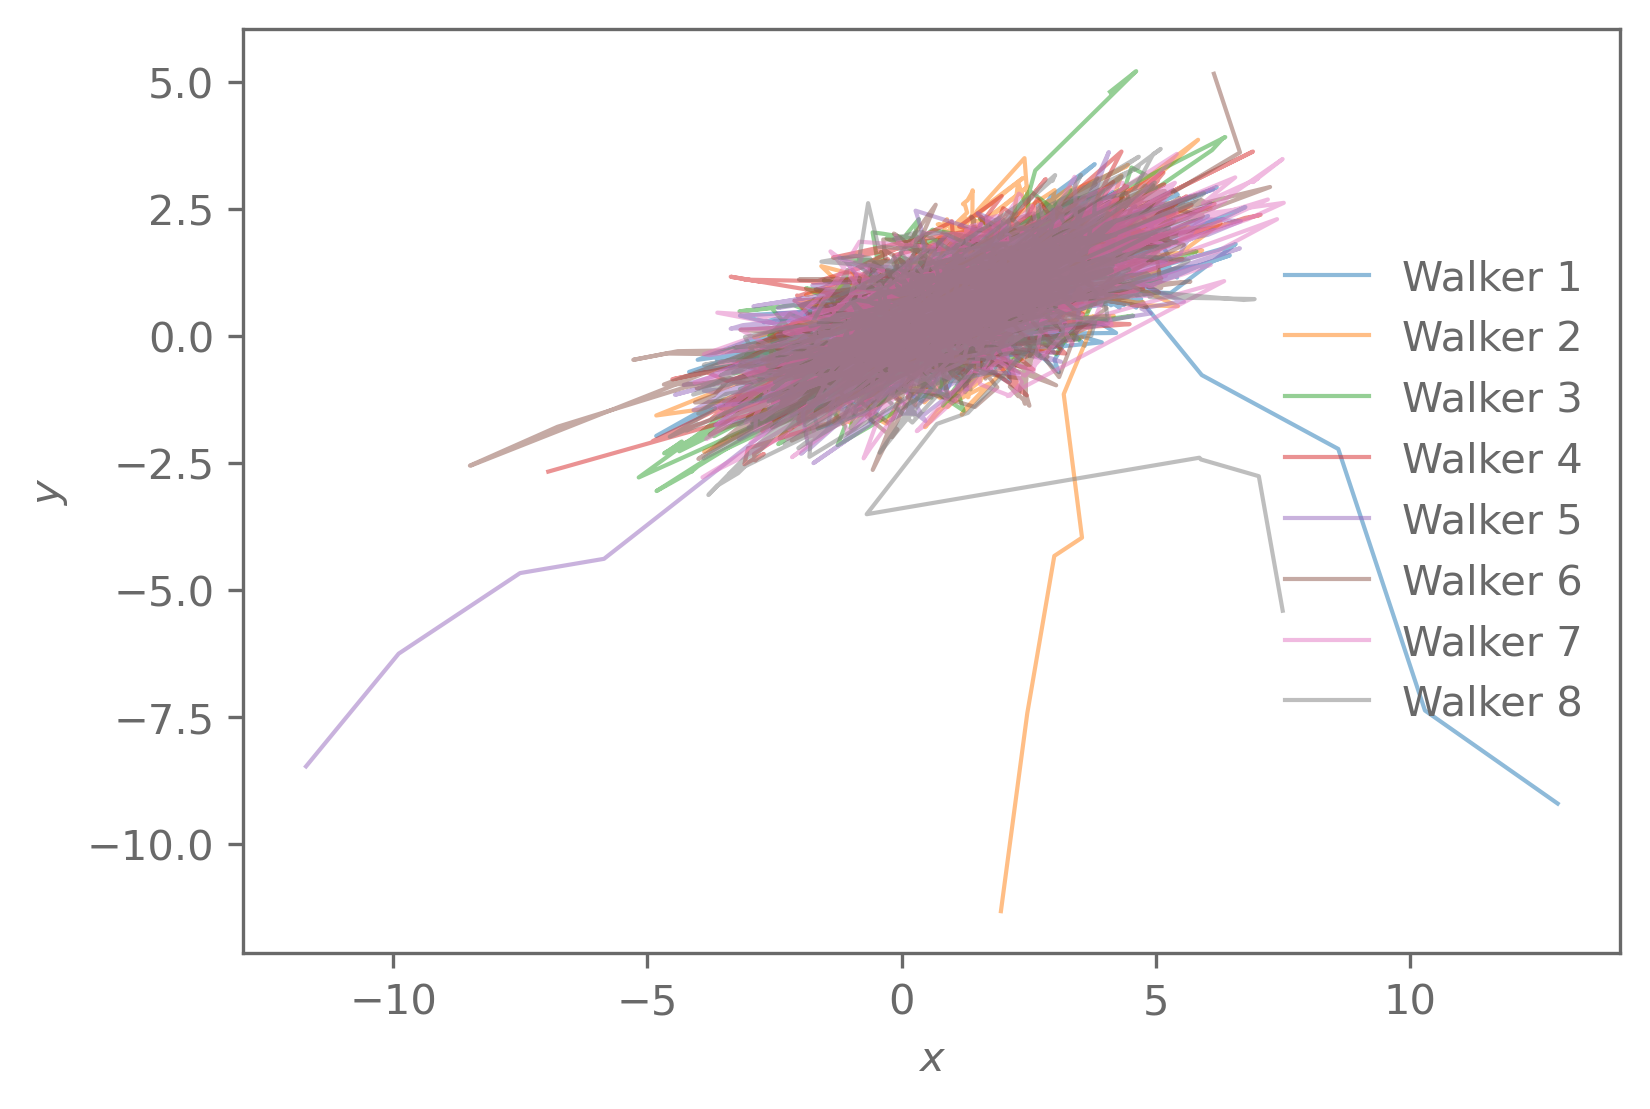

In [69]:
# Get the samples from the chain and plot it
chain = sampler.get_chain()

fig, ax = plt.subplots()
for i in range(n_walker):
    ax.plot(*chain[:, i].T, lw=1, alpha=0.5, color=f"C{i}", label=f"Walker {i+1}")

ax.set_aspect("equal")
ax.legend(frameon=False)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

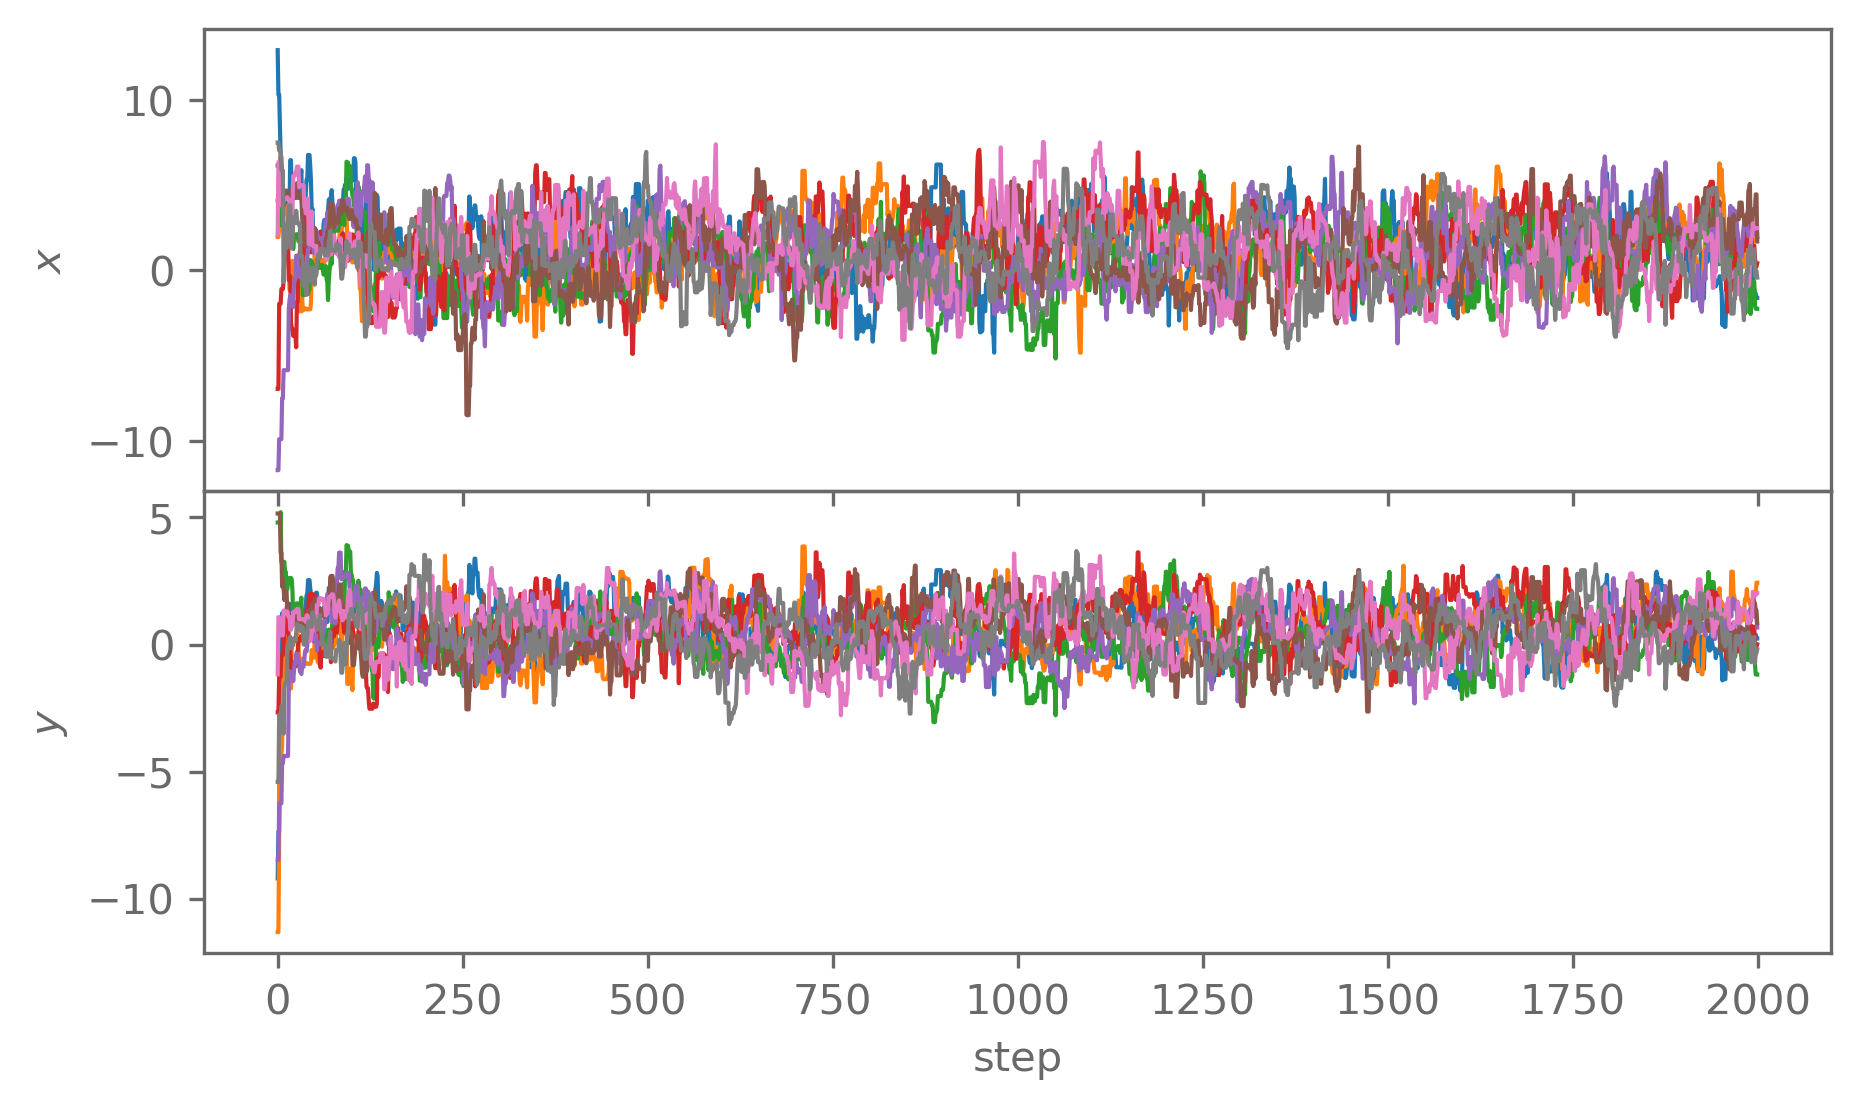

In [70]:
# Plot the tracer of the chain, this time for all the walkers
fig, ax = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=0)

for i in range(n_walker):
    ax[0].plot(chain[:, i, 0], lw=1, color=f"C{i}")
    ax[1].plot(chain[:, i, 1], lw=1, color=f"C{i}")

ax[0].set_ylabel("$x$")
ax[1].set_ylabel("$y$")
ax[1].set_xlabel("step");

In [71]:
# Measure the autocorrelation time to see
sampler.get_autocorr_time()

array([36.43836535, 35.04277883])

In [73]:
# Get the chain with the burn-in removed, thinned, 
# and flattened (combine the walkers)
chain = sampler.get_chain(discard=200, thin=20, flat=True)

chain.shape

(720, 2)

# Detailed Balance of the MH algorithm

Using the hint, the transition probability $T(x | y)$ is given by  $T(x | y) =  q(x | y) a(x | y)$, where $a(x | y) = \mathrm{min}\left(1, \frac{p(x) q(y | x)}{p(y) q(x | y)}\right)$ and $q(x | y)$, $p(x)$ are the proposal and target distribution respectively. 
This is because we first draw from the proposal distribution and then accept the point according to $a$, giving a total transition probability $T(x | y)$.
Detailed balance requires 
$$ \frac{T(x | y)}{T(y | x)} = \frac{p(x)}{p(y)}.$$
Plugging in our transition probability and rewriting gives
$$ \frac{a(x | y)}{a(y | x)} = \frac{p(x) q(y | x)}{p(y)q(x | y)}.$$
This is always fulfilled because if $a(x | y) = 1$, $a(y | x)$ equals the ratio $\frac{p(y) q(x | y)}{p(x) q(y | x)}$ and vice versa. 

This is special to the Metropolis Hastings algorithm, where $a$ is chosen exactly like that such that detailed balance is always satisfied, independent of the choice of proposal distribution.
